## Data Loader

In [1]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np
import time
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import pdb
from PIL import Image
from matplotlib import pyplot as plt
import argparse
torch.manual_seed(0)

import torch.nn as nn
import torch.nn.functional as F

print('Using PyTorch version', torch.__version__)


from os.path import isfile
from os import rename
SMOOTH=1
import pdb
from sklearn.metrics import auc, roc_curve
from PIL.ImageFilter import GaussianBlur

# import pdb
from numpy import pi as PI
from numpy import sqrt
from scipy.special import comb
import math
# tensorflow libraries
# import tensorflow as tf
# from tensorflow import keras
# from keras.preprocessing.image import ImageDataGenerator

Using PyTorch version 1.11.0


In [2]:
# pytorch res, res101..

# Tying papers -> Take inputs from the papers and comparision
# Implementing. LeNet
# EDA. More about Dataset
# Data Augmentation -> Its Benifits
# Can use different dataset on top of this
# Loss plots

In [3]:
# Miscellaneous initialization
torch.manual_seed(1)
start_time = time.time()
parser = argparse.ArgumentParser()

In [4]:
train_dataset_path = ""
test_dataset_path = ""

In [5]:
root_dir = "/Users/harshitb/Desktop/Studies/ECE 228/TB_dataset/TB_Chest_Radiography_Database"
class_names = ['Normal', 'Tuberculosis']
source_dirs = ['Normal', 'Tuberculosis']

In [6]:
parser.add_argument('--num_epochs', type=int, default=5, help='Number of training epochs')
parser.add_argument('--batch_size', type=int, default=32, help='Batch size')
parser.add_argument('--lr', type=float, default=5e-4, help='Learning rate')
parser.add_argument('--l2', type=float, default=0, help='L2 regularisation')
parser.add_argument('--aug', action='store_true', default=False, help='Use data augmentation')
parser.add_argument('--data_path', type=str, default=root_dir,help='Path to data.')
parser.add_argument('--bond_dim', type=int, default=5, help='MPS Bond dimension')
parser.add_argument('--nChannel', type=int, default=1, help='Number of input channels')
parser.add_argument('--dense_net', action='store_true', default=False, help='Using Dense Net model')

args = parser.parse_args([])

In [7]:
batch_size = args.batch_size

# LoTeNet parameters
adaptive_mode = False 
periodic_bc   = False

kernel = 2 # Stride along spatial dimensions
output_dim = 1 # output dimension
 
feature_dim = 2

#logFile = time.strftime("%Y%m%d_%H_%M")+'.txt'
#makeLogFile(logFile)

normTensor = 0.5*torch.ones(args.nChannel)
### Data processing and loading....


In [8]:
### Data processing and loading....
# mean=[0.485, 0.456, 0.406], std=[0.229,0.224,0.225]
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.Resize(size=(256,256)),
#                                       transforms.RandomVerticalFlip(),
#                                       transforms.RandomRotation(20),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=normTensor,std=normTensor)])

valid_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(256,256)),
#     torchvision.transforms.RandomHorizontalFlip(),
#     torchvision.transforms.RandomRotation(20),
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean=normTensor,std=normTensor)
    #torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.224,0.225])
])

In [9]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs,transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)}{class_name}')
            return images
        self.images={}
        self.class_names=['Normal', 'Tuberculosis']
        for c in self.class_names:
            self.images[c]=get_images(c)
        self.image_dirs=image_dirs
        self.transform=transform
        
    
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    def __getitem__(self, index):
        class_name=random.choice(self.class_names)
        index=index%len(self.images[class_name])
        image_name=self.images[class_name][index]
        image_path =os.path.join(self.image_dirs[class_name], image_name)
        image=Image.open(image_path).convert('L')
        return self.transform(image), self.class_names.index(class_name)

In [10]:
train_dirs = {
    'Normal': root_dir + '/Normal',
    'Tuberculosis': root_dir + '/Tuberculosis'
}
dataset = ChestXRayDataset(train_dirs, train_transform)

Found 3500Normal
Found 700Tuberculosis


In [11]:
f,l = dataset[0]

In [12]:
len(dataset)

4200

In [13]:
trainset, testset, valset = random_split(dataset, [3500, 500, 200])

In [14]:
train_loader =  torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader =  torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)

In [15]:
args.num_epochs = 5
batch_size

32

In [16]:
# num_epochs = args.num_epochs
# total_samples = 3500
# n_iterations = math.ceil(total_samples/batch_size)
# for epoch in range(args.num_epochs):
#     for i, (inputs, labels) in enumerate(train_loader):
#         if (i+1) % 10 == 0:
#             print(f'Epoch: {epoch+1}/{num_epochs}, \
#                     Step {i+1}/{n_iterations}| Inputs {inputs.shape} | Labels {labels.shape}')

In [17]:
x = inputs

conv1 = nn.Conv2d(1, 6, 5)
x = conv1(x)
print("C1: ", x.shape)

# pool = nn.MaxPool2d(2, 2)
# x = pool(x)
# print("P1: ", x.shape)

conv2 = nn.Conv2d(6, 16, 5)
x = conv2(x)
print("C2: ", x.shape)

# x = pool(x)
# print("P1: ", x.shape)

xl = 1
for i in x.shape[1:]: xl *= i
print(xl)
fc1 = nn.Linear(xl, 120)
x = x.view(-1, xl) 
x = fc1(x)
print("F1: ", x.shape)

# self.fc1 = nn.Linear(16 * 5 * 5, 120)
# self.fc2 = nn.Linear(120, 84)
# self.fc3 = nn.Linear(84, 10)

NameError: name 'inputs' is not defined

In [18]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        #         xl = 1
        #         for i in x.shape[1:]: xl *= i
        #         self.fc1 = nn.Linear(13456, 120)
        self.fc1 = nn.Linear(984064, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        # -> n, 3, 32, 32
        #         x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
        #         x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv1(x))  # -> n, 6, 14, 14
        x = F.relu(self.conv2(x))
        xl = 1
        for i in x.shape[1:]: xl *= i
        x = x.view(-1, xl)            # 
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 2
        return x

In [19]:
#Defining the convolutional neural network
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(59536, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, 2)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [281]:
x = inputs

layer1 = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
    nn.BatchNorm2d(6),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2))
x = layer1(x)
print("L1: ", x.shape)

layer2 = nn.Sequential(
    nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2))
x = layer2(x)
print("L2: ", x.shape)

fc = nn.Linear(22326, 120)
relu = nn.ReLU()
fc1 = nn.Linear(120, 84)
relu1 = nn.ReLU()
fc2 = nn.Linear(84, 2)

x = x.reshape(x.size(0), -1)
x.shape

L1:  torch.Size([32, 6, 126, 126])
L2:  torch.Size([32, 16, 61, 61])


torch.Size([32, 59536])

In [35]:
%%time

model = LeNet5()
learning_rate = 0.001
all_loss = []

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)
for epoch in range(args.num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        all_loss.append(loss.item())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print (f'Epoch [{epoch+1}/{args.num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [1/5], Step [10/110], Loss: 0.6293
Epoch [1/5], Step [20/110], Loss: 0.5562
Epoch [1/5], Step [30/110], Loss: 0.4644
Epoch [1/5], Step [40/110], Loss: 0.5148
Epoch [1/5], Step [50/110], Loss: 0.4203
Epoch [1/5], Step [60/110], Loss: 0.3515
Epoch [1/5], Step [70/110], Loss: 0.2732
Epoch [1/5], Step [80/110], Loss: 0.3421
Epoch [1/5], Step [90/110], Loss: 0.3092
Epoch [1/5], Step [100/110], Loss: 0.2660
Epoch [1/5], Step [110/110], Loss: 0.2022
Epoch [2/5], Step [10/110], Loss: 0.1592
Epoch [2/5], Step [20/110], Loss: 0.2636
Epoch [2/5], Step [30/110], Loss: 0.2635
Epoch [2/5], Step [40/110], Loss: 0.3050
Epoch [2/5], Step [50/110], Loss: 0.3014
Epoch [2/5], Step [60/110], Loss: 0.1261
Epoch [2/5], Step [70/110], Loss: 0.2045
Epoch [2/5], Step [80/110], Loss: 0.2076
Epoch [2/5], Step [90/110], Loss: 0.1968
Epoch [2/5], Step [100/110], Loss: 0.3683
Epoch [2/5], Step [110/110], Loss: 0.1696
Epoch [3/5], Step [10/110], Loss: 0.1192
Epoch [3/5], Step [20/110], Loss: 0.1805
Epoch [3/5],

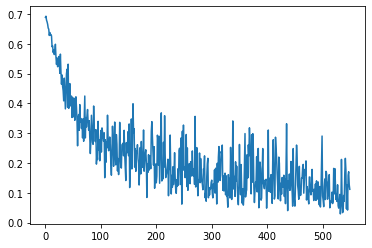

In [38]:
plt.plot(all_loss)

In [287]:
def get_acc_from_data(d_loader):
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for i in range(2)]
        n_class_samples = [0 for i in range(2)]
        for images, labels in d_loader:
            #         print(len(labels))
            outputs = model(images)
            # max returns (value ,index)
            _, predicted = torch.max(outputs, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

            for i in range(len(labels)):
                label = labels[i]
                pred = predicted[i]
                if (label == pred):
                    n_class_correct[label] += 1
                n_class_samples[label] += 1

        acc = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network: {acc} %')

        for i in range(2):
            acc = 100.0 * n_class_correct[i] / n_class_samples[i]
            print(f'Accuracy of {class_names[i]}: {acc} %')

In [288]:
get_acc_from_data(test_loader)

Accuracy of the network: 96.0 %
Accuracy of Normal: 96.52509652509653 %
Accuracy of Tuberculosis: 95.4356846473029 %


In [289]:
get_acc_from_data(val_loader)

Accuracy of the network: 97.0 %
Accuracy of Normal: 97.32142857142857 %
Accuracy of Tuberculosis: 96.5909090909091 %
